<a href="https://colab.research.google.com/github/LuisHenriqueBertiVeloso/Projetos-de-Analise-de-Dados/blob/main/NBA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from statsmodels.tsa.seasonal import seasonal_decompose
!pip install pmdarima
from pmdarima.arima import auto_arima
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [227]:
details_df = pd.read_csv('games_details.csv')
games_df = pd.read_csv('games.csv')

In [228]:
lst = [details_df,games_df]

for x in lst:
    print(x.columns)

Index(['GAME_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_CITY', 'PLAYER_ID',
       'PLAYER_NAME', 'NICKNAME', 'START_POSITION', 'COMMENT', 'MIN', 'FGM',
       'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT',
       'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TO', 'PF', 'PTS',
       'PLUS_MINUS'],
      dtype='object')
Index(['GAME_DATE_EST', 'GAME_ID', 'GAME_STATUS_TEXT', 'HOME_TEAM_ID',
       'VISITOR_TEAM_ID', 'SEASON', 'TEAM_ID_home', 'PTS_home', 'FG_PCT_home',
       'FT_PCT_home', 'FG3_PCT_home', 'AST_home', 'REB_home', 'TEAM_ID_away',
       'PTS_away', 'FG_PCT_away', 'FT_PCT_away', 'FG3_PCT_away', 'AST_away',
       'REB_away', 'HOME_TEAM_WINS'],
      dtype='object')


In [357]:
base_1 = details_df[['GAME_ID','PLAYER_NAME','PTS','FGM','FG3M','FGA','FG3A','MIN','FG_PCT','FG3_PCT','STL', 'BLK', 'TO', 'PF']]
base_2 = games_df[['GAME_DATE_EST','GAME_ID','HOME_TEAM_WINS','PTS_home', 'PTS_away','FG_PCT_home','FG_PCT_away']]
base_1.dropna(inplace=True)
df = pd.merge(base_1,base_2, on='GAME_ID', how='left')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 559678 entries, 0 to 559677
Data columns (total 20 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   GAME_ID         559678 non-null  int64  
 1   PLAYER_NAME     559678 non-null  object 
 2   PTS             559678 non-null  float64
 3   FGM             559678 non-null  float64
 4   FG3M            559678 non-null  float64
 5   FGA             559678 non-null  float64
 6   FG3A            559678 non-null  float64
 7   MIN             559678 non-null  object 
 8   FG_PCT          559678 non-null  float64
 9   FG3_PCT         559678 non-null  float64
 10  STL             559678 non-null  float64
 11  BLK             559678 non-null  float64
 12  TO              559678 non-null  float64
 13  PF              559678 non-null  float64
 14  GAME_DATE_EST   559678 non-null  object 
 15  HOME_TEAM_WINS  559678 non-null  int64  
 16  PTS_home        559678 non-null  float64
 17  PTS_away  

In [358]:
df['GAME_DATE_EST'] = pd.to_datetime(df['GAME_DATE_EST'], format = '%Y/%m/%d')
df['ANO'] = df['GAME_DATE_EST'].dt.strftime('%Y-%m')
df[['Minutos', 'segundos']] = df['MIN'].str.split(':', expand=True)
df['Minutos'] = df['Minutos'].astype(float)

In [232]:
df.head(5)

,GAME_ID,PLAYER_NAME,PTS,FGM,FG3M,FGA,FG3A,MIN,FG_PCT,FG3_PCT,...,PF,GAME_DATE_EST,HOME_TEAM_WINS,PTS_home,PTS_away,FG_PCT_home,FG_PCT_away,ANO,Minutos,segundos
0,22200477,Romeo Langford,2.0,1.0,0.0,1.0,0.0,18:06,1.000,0.000,...,5.0,2022-12-22,1,126.0,117.0,0.484,0.478,2022-12,18.0,06
1,22200477,Jeremy Sochan,23.0,7.0,2.0,14.0,4.0,31:01,0.500,0.500,...,1.0,2022-12-22,1,126.0,117.0,0.484,0.478,2022-12,31.0,01
2,22200477,Jakob Poeltl,13.0,6.0,0.0,9.0,0.0,21:42,0.667,0.000,...,4.0,2022-12-22,1,126.0,117.0,0.484,0.478,2022-12,21.0,42
3,22200477,Devin Vassell,10.0,4.0,1.0,13.0,6.0,30:20,0.308,0.167,...,1.0,2022-12-22,1,126.0,117.0,0.484,0.478,2022-12,30.0,20
4,22200477,Tre Jones,19.0,7.0,1.0,12.0,3.0,27:44,0.583,0.333,...,2.0,2022-12-22,1,126.0,117.0,0.484,0.478,2022-12,27.0,44


In [359]:
df_vitoria = df[df['HOME_TEAM_WINS']==1]
df_derrotas = df[df['HOME_TEAM_WINS']==0]
df_vitoria.set_index('GAME_ID', inplace=True)
df_derrotas.set_index('GAME_ID', inplace=True)

In [360]:
pivot = df.pivot_table(index='ANO', columns='PLAYER_NAME', values='PTS', aggfunc='sum')
pivot.fillna(0,inplace=True)
pivot.groupby(by=pivot.index)
pivot['DATA'] = pd.DatetimeIndex(pivot.index).year
pivot.reset_index()
pivot = pivot.groupby(by='DATA').mean()

In [361]:
pivot_fgm = df.pivot_table(index='ANO', columns='PLAYER_NAME', values='FGM', aggfunc='sum')
pivot_fgm.fillna(0,inplace=True)
pivot_fgm.groupby(by=pivot_fgm.index)
pivot_fgm['DATA'] = pd.DatetimeIndex(pivot_fgm.index).year
pivot_fgm.reset_index()
pivot_fgm = pivot_fgm.groupby(by='DATA').mean()

In [362]:
pivot_fg3m = df.pivot_table(index='ANO', columns='PLAYER_NAME', values='FG3M', aggfunc='sum')
pivot_fg3m.fillna(0,inplace=True)
pivot_fg3m.groupby(by=pivot_fg3m.index)
pivot_fg3m['DATA'] = pd.DatetimeIndex(pivot_fg3m.index).year
pivot_fg3m.reset_index()
pivot_fg3m = pivot_fg3m.groupby(by='DATA').mean()

In [363]:
x = df.groupby(by='PLAYER_NAME').sum().sort_values(by='PTS',ascending=False)
y = df.groupby(by='PLAYER_NAME').sum().sort_values(by='FGM',ascending=False)
z =  df.groupby(by='PLAYER_NAME').sum().sort_values(by='FG3M',ascending=False)
x = x.iloc[0:5]
y = y.iloc[0:5]
z = z.iloc[0:5]
x.reset_index(inplace=True)
y.reset_index(inplace=True)
z.reset_index(inplace=True)

### **EDA - Análise Exploratória dos dados**


---



Text(0.5, 1.0, 'CESTAS DE 3 PONTOS - 5 MAIORES JOG')

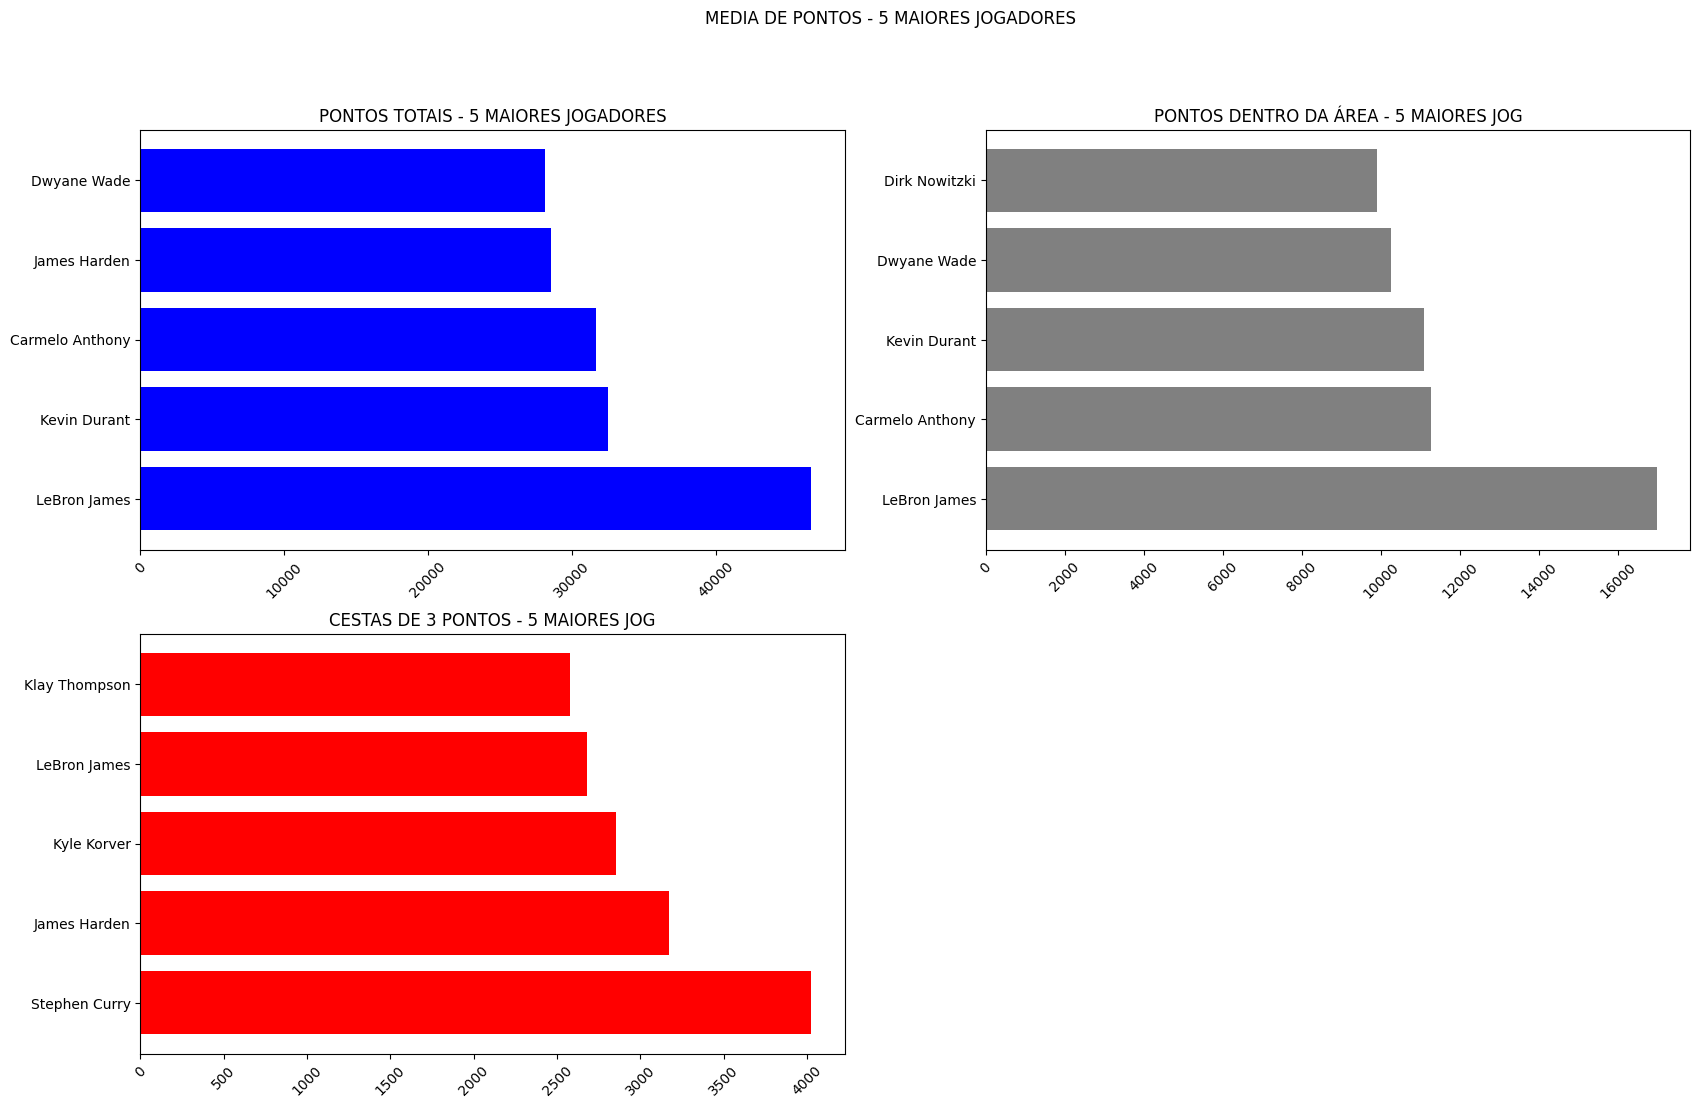

In [238]:
x['PONTOS_TOTAIS'] = x['FGM'] + x['FG3M']


plt.figure(figsize=(20,12))
plt.suptitle(t='MEDIA DE PONTOS - 5 MAIORES JOGADORES')

plt.subplot(2,2,1)
plt.barh(y = x['PLAYER_NAME'], width='PTS', data=x, color='b');
plt.xticks(rotation=45);
plt.title('PONTOS TOTAIS - 5 MAIORES JOGADORES')

plt.subplot(2,2,2)
plt.barh(y=y['PLAYER_NAME'], width='FGM', data=y, color='gray')
plt.xticks(rotation=45)
plt.title('PONTOS DENTRO DA ÁREA - 5 MAIORES JOG')

plt.subplot(2,2,3)
plt.barh(y=z['PLAYER_NAME'], width='FG3M', data=z, color='r')
plt.xticks(rotation=45)
plt.title('CESTAS DE 3 PONTOS - 5 MAIORES JOG')

In [ ]:
#dos 5 jogadores das temporadas de 2004 até 2022, o maior pontuador total é LeBron James, já o maior cestinha de
# 3 pontos é Stephen Curry, seguido de James Harden que também se destaca como um dos maiores pontuadores, dessa forma, por mais que James Harden seja o segundo
#maior cestinho, ele aparenta ser mais decisivo para soma de pontos que Stephen Curry

In [367]:
a = df['PTS'].max()
df.loc[df['PTS'] == a ]

,GAME_ID,PLAYER_NAME,PTS,FGM,FG3M,FGA,FG3A,MIN,FG_PCT,FG3_PCT,...,PF,GAME_DATE_EST,HOME_TEAM_WINS,PTS_home,PTS_away,FG_PCT_home,FG_PCT_away,ANO,Minutos,segundos
189956,20500591,Kobe Bryant,81.0,28.0,7.0,46.0,13.0,41:56,0.609,0.538,...,1.0,2006-01-22,1,122.0,104.0,0.477,0.474,2006-01,41.0,56


In [ ]:
#Kobe Bryant mantém o recorde de pontos em uma partida - 81PTS

In [376]:
wins = df.pivot_table(index='PLAYER_NAME', values='HOME_TEAM_WINS', aggfunc='sum')
wins = wins.sort_values(by='HOME_TEAM_WINS', ascending=False)
wins.iloc[0:2]

,HOME_TEAM_WINS
PLAYER_NAME,
LeBron James,1039
Kyle Korver,879


In [ ]:
#LeBron James é o jogador com mais vitórias com seu time - somando 1039 vitórias, seguindo de Kyle Korver com 879

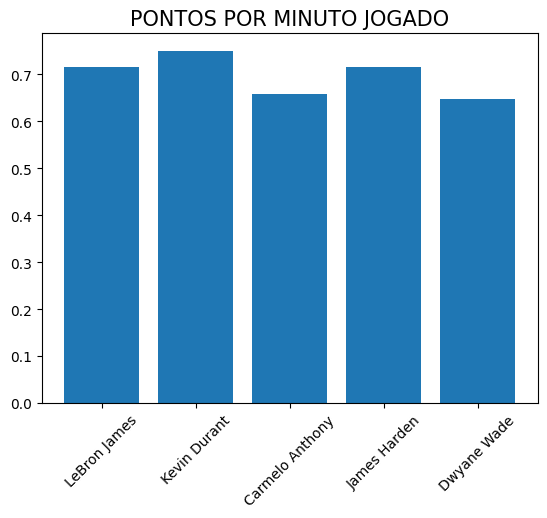

In [364]:
x['PTS_MIN'] = x['PTS'] / x['Minutos']
plt.bar(x=x['PLAYER_NAME'], height='PTS_MIN', data=x);
plt.title('PONTOS POR MINUTO JOGADO', fontsize=15)
plt.xticks(rotation=45);

In [ ]:
#dentre os 5 maiores de 2004 a 2022, Kevin Durant e James Harden são os maiores pontuadores por minuto jogado

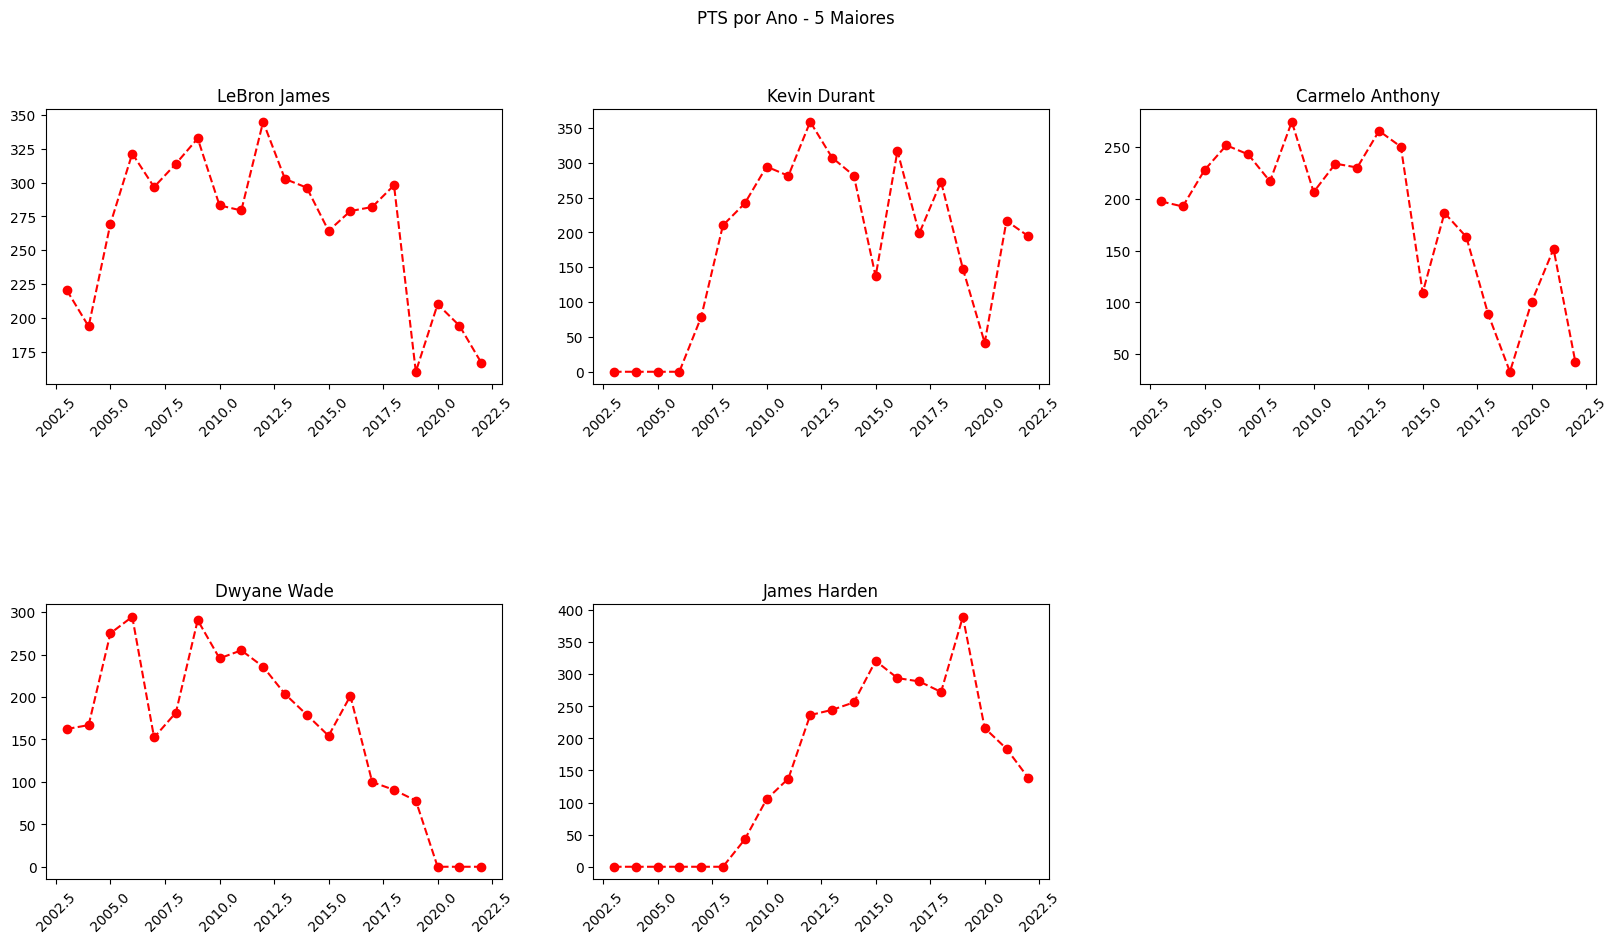

In [240]:
lst = ['LeBron James', 'Kevin Durant', 'Carmelo Anthony', 'Dwyane Wade',
       'James Harden']


plt.figure(figsize=(20,10))
plt.suptitle('PTS por Ano - 5 Maiores')
for x in range(len(lst)):
  plt.subplot(2,3,x+1)
  plt.subplots_adjust(hspace=0.8)
  plt.plot(pivot[lst[x]], marker='o', ls='--', color='r')
  plt.title(lst[x])
  plt.xticks(rotation=45)

In [ ]:
#Por mais que LeBron James seja o maior pontuador, James Harden foi o jogador que mais variou seus pontos, entre 0 e 400 pontos, atingindo o pico máximo dentre os maiores pontuadores.
#Além disso, LeBron vem tendo os piores números de sua carreira, mas mesmo depois de 18 anos ainda mantém um alto número de PTS por temporada

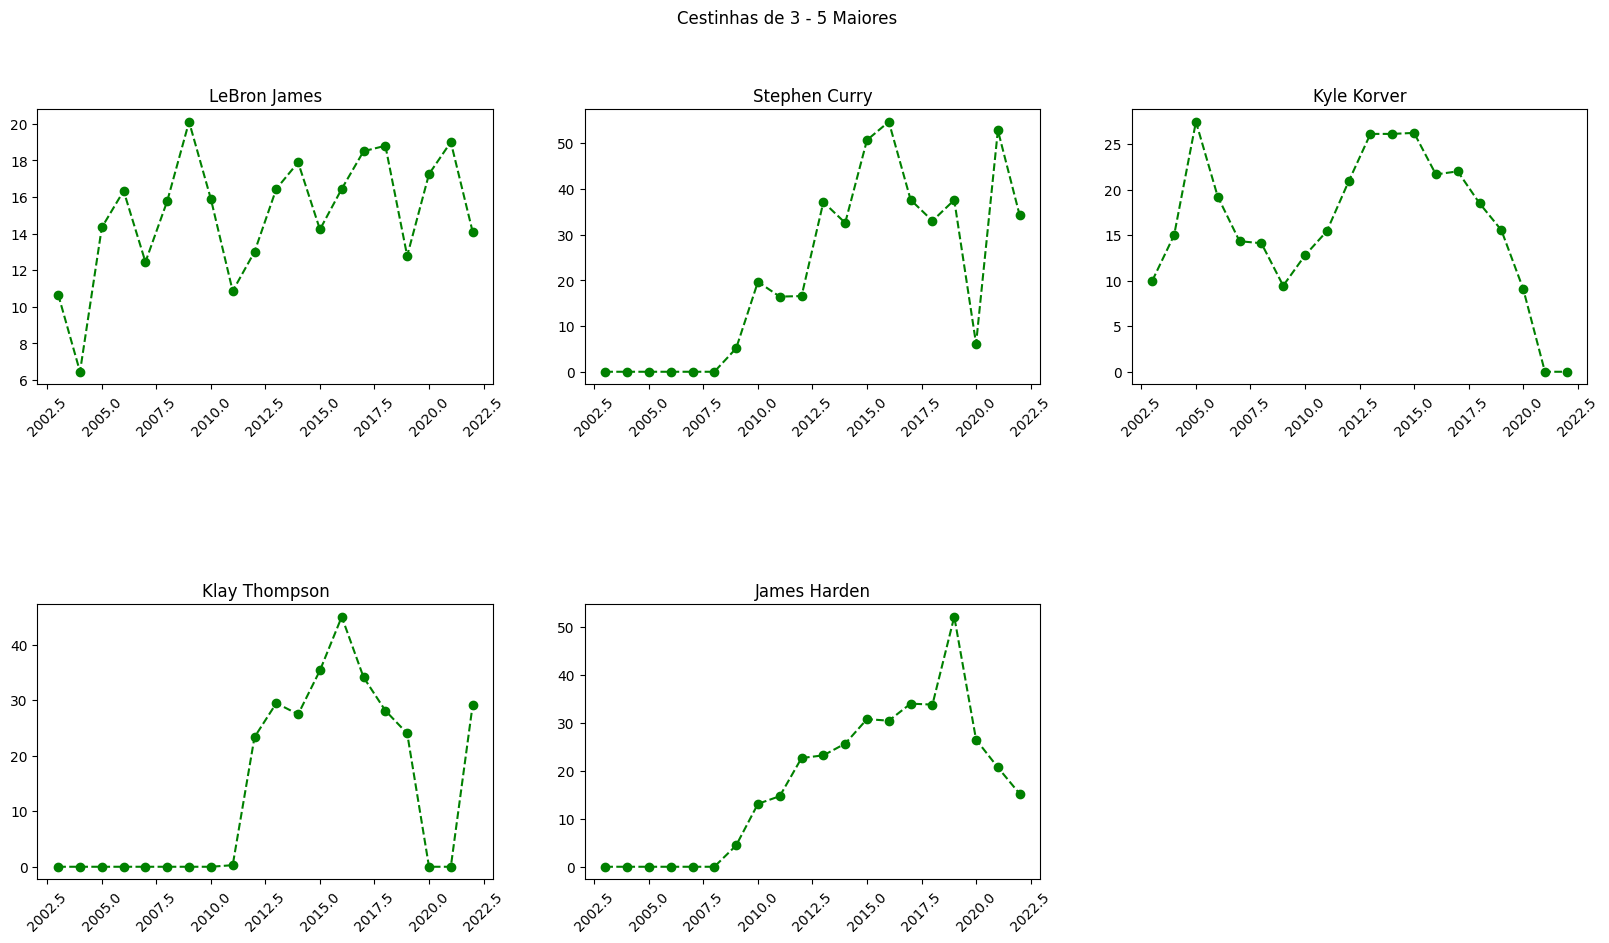

In [242]:
lst = ['LeBron James', 'Stephen Curry', 'Kyle Korver', 'Klay Thompson',
       'James Harden']


plt.figure(figsize=(20,10))
plt.suptitle('Cestinhas de 3 - 5 Maiores')
for x in range(len(lst)):
  plt.subplot(2,3,x+1)
  plt.subplots_adjust(hspace=0.8)
  plt.plot(pivot_fg3m[lst[x]], marker='o', ls='--', color='green')
  plt.title(lst[x])
  plt.xticks(rotation=45)

In [ ]:
#Nas cestas de 3 pontos, ninguém se compara à Stephen Curry, como recordista, Stephen Curry atingiu, dentre os 5 maiores cestinhas de 3, o pico mais alto de pontos em 2015,
#mesmo tendo tido um decaimento em 2020, sua capacidade voltou a subir

Text(0.5, 1.0, 'COMPARAÇÃO ANUAL DOS DOIS MAIORES PONTUADORES')

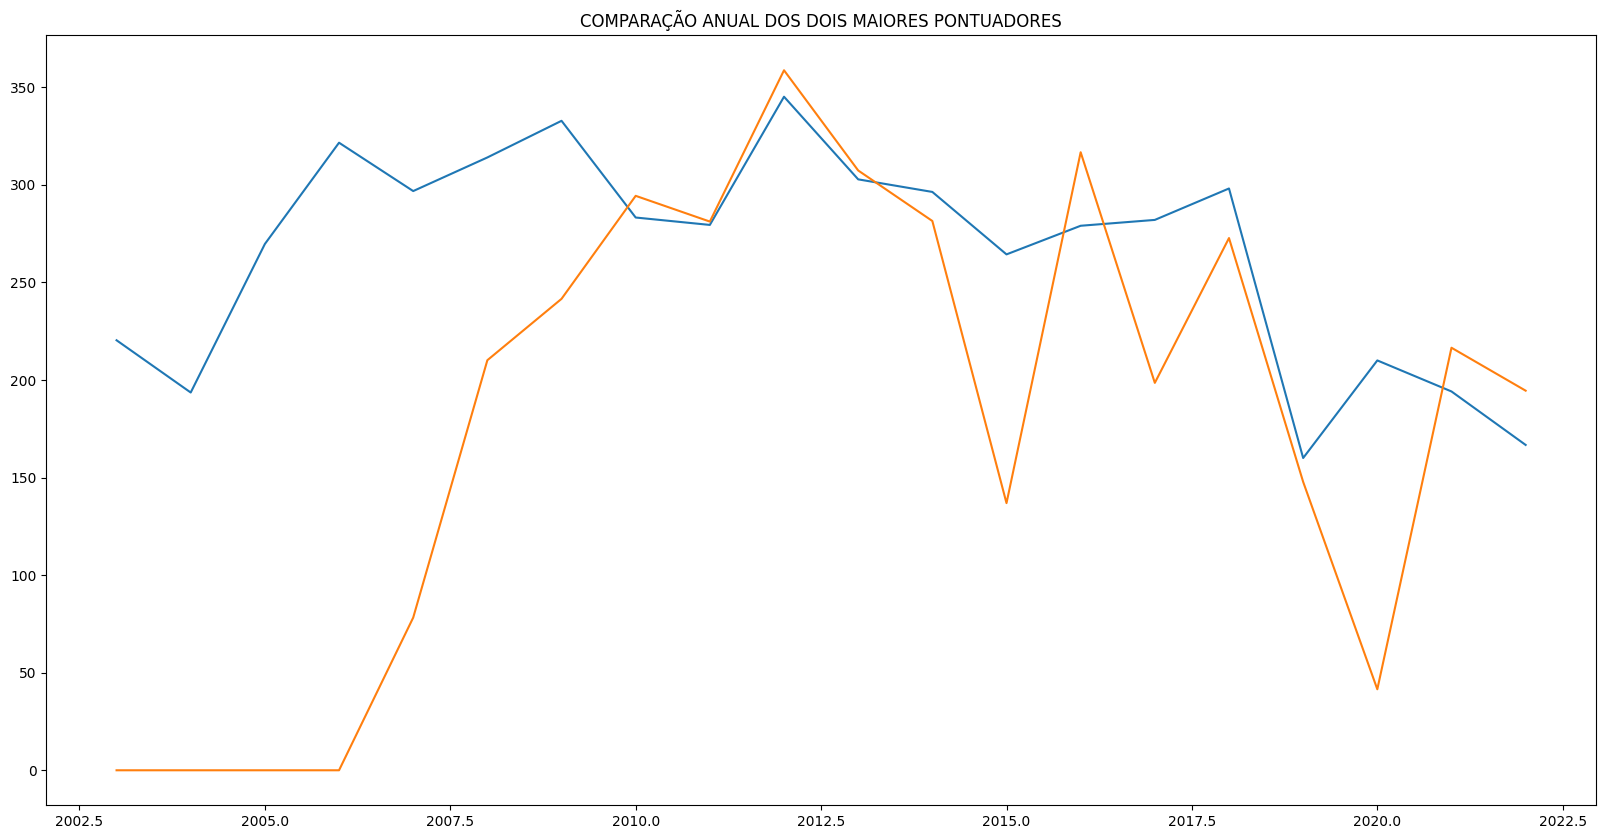

In [243]:
x = pivot['LeBron James']
y = pivot['Kevin Durant']

plt.figure(figsize=(20,10))
plt.plot(x)
plt.plot(y)
plt.title('COMPARAÇÃO ANUAL DOS DOIS MAIORES PONTUADORES')

In [ ]:
#mesmo mais velho, LeBron James se manteve à mais tempo em alto nível, superando Kevin Durant em quase todas as temporadas

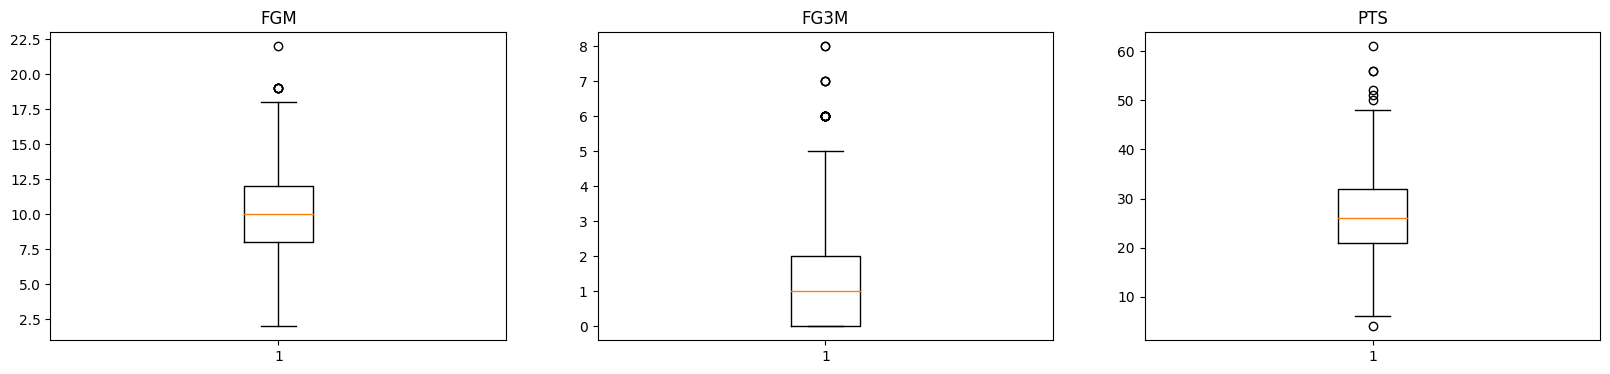

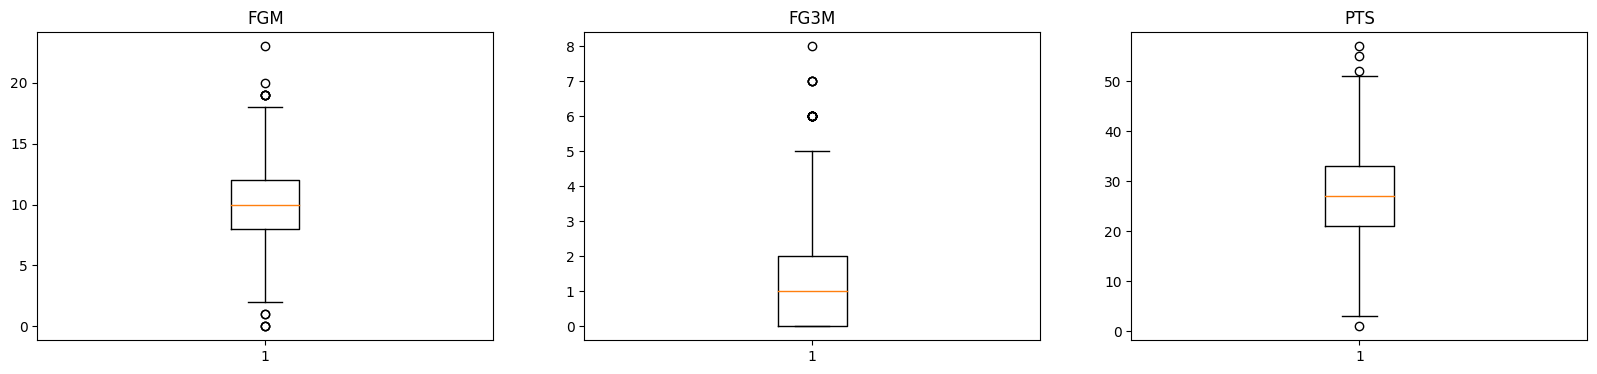

In [244]:
x = df_vitoria[df_vitoria['PLAYER_NAME'] == 'LeBron James']
lst = ['FGM','FG3M','PTS']
plt.figure(figsize=(20,12))
for i in range(len(lst)):
  plt.subplot(2,3,i+1)
  plt.subplots_adjust(hspace=1)
  plt.title(lst[i])
  plt.boxplot(x[lst[i]])

y = df_derrotas[df_derrotas['PLAYER_NAME'] == 'LeBron James']
lst = ['FGM','FG3M','PTS']
plt.figure(figsize=(20,12))
for i in range(len(lst)):
  plt.subplot(2,3,i+1)
  plt.subplots_adjust(hspace=1)
  plt.title(lst[i])
  plt.boxplot(y[lst[i]])

In [ ]:
#LeBron James mantém maior amplitude de FGM (cesta de 2 pts.) concentrado em partidas de Vitórias. Em pontos de 3 ele mantém praticamente o mesmo desempenho tanto em vitórias quanto em derrotas
#Já em partidas de vitórias, LeBron tem mais outliers, podendo indicar que teve mais performances excepcionais em vitórias que em derrotas

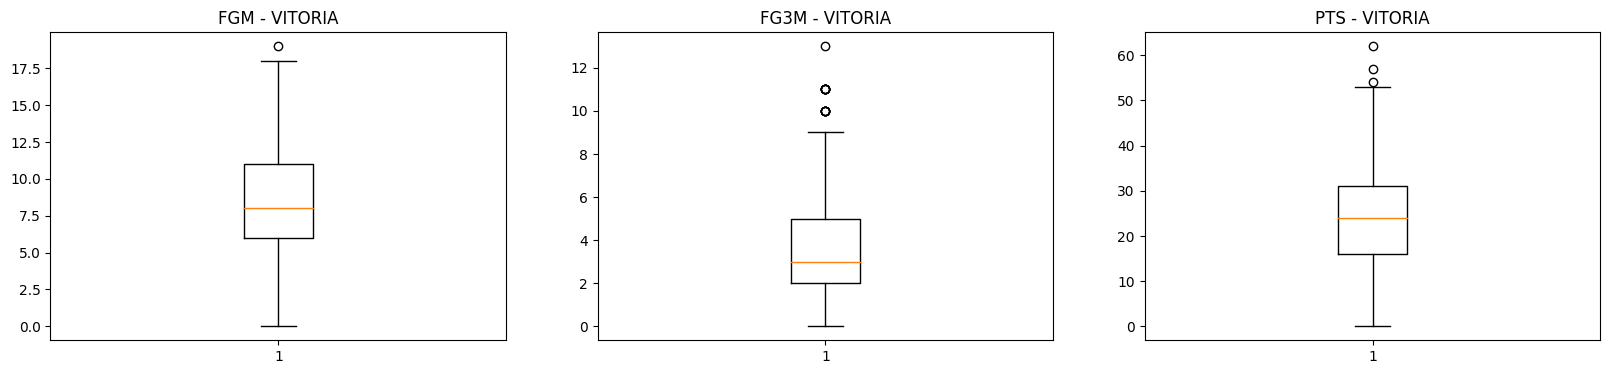

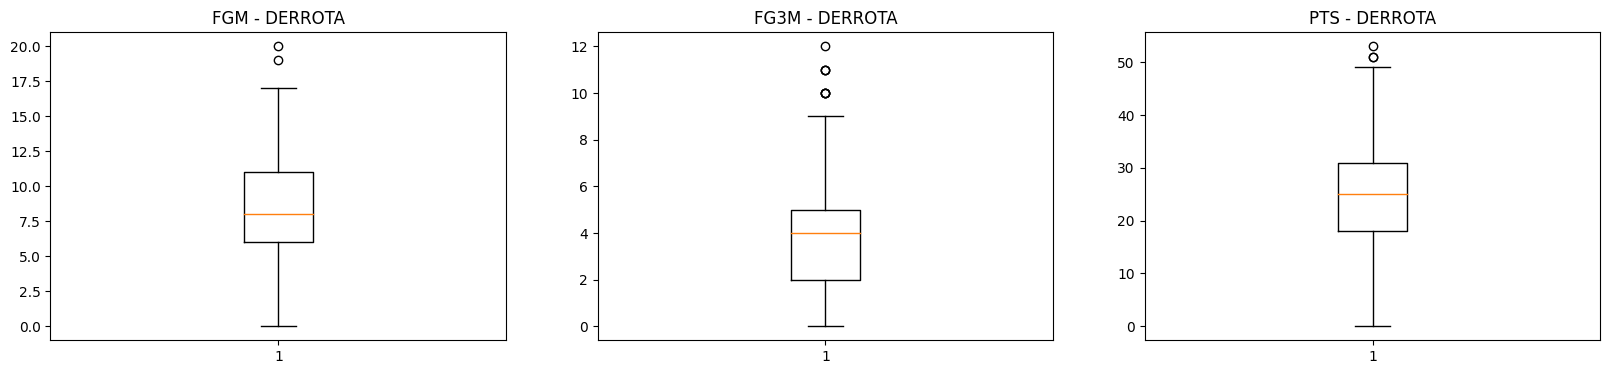

In [245]:
x = df_vitoria[df_vitoria['PLAYER_NAME'] == 'Stephen Curry']
y = df_derrotas[df_derrotas['PLAYER_NAME'] == 'Stephen Curry']

lst = ['FGM','FG3M','PTS']
plt.figure(figsize=(20,12))
for i in range(len(lst)):
  plt.subplot(2,3,i+1)
  plt.subplots_adjust(hspace=1)
  plt.title(lst[i]+' - VITORIA')
  plt.boxplot(x[lst[i]])


lst = ['FGM','FG3M','PTS']
plt.figure(figsize=(20,12))
for i in range(len(lst)):
  plt.subplot(2,3,i+1)
  plt.subplots_adjust(hspace=1)
  plt.title(lst[i]+' - DERROTA')
  plt.boxplot(y[lst[i]])

In [ ]:
#Stephen mantém quase o mesmo padrão em relação de cestas de três pontos tanto em vitórias quanto em derrotas, porém em derrotas os dados são mais concentrados
#abaixo de sua mediana - menor que 50%

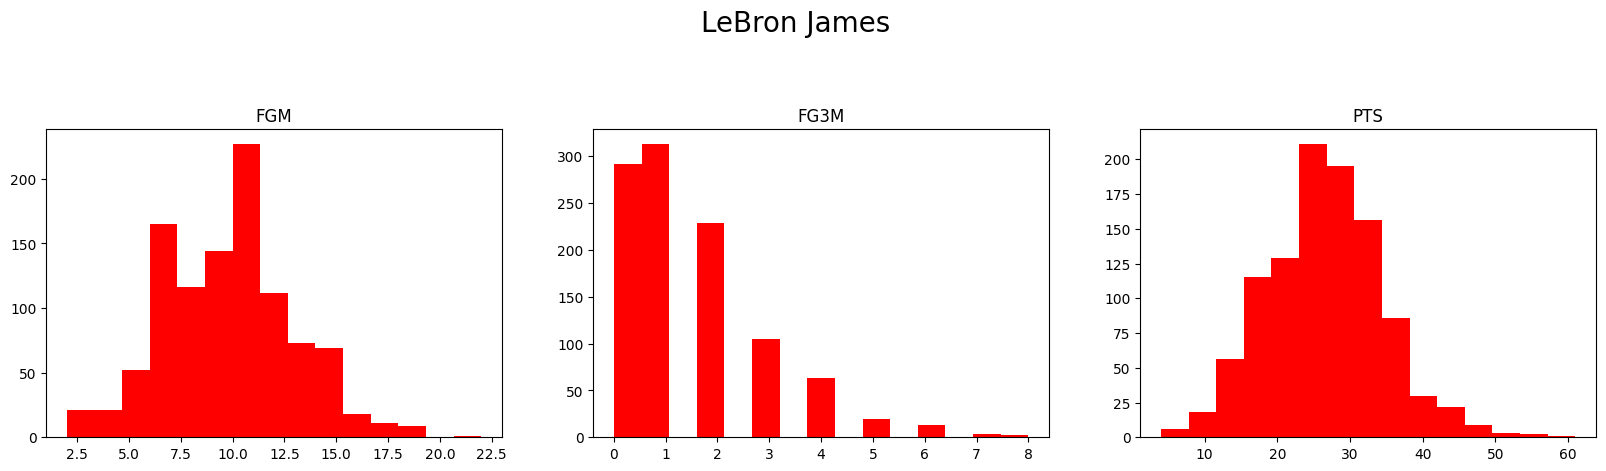

In [246]:
x = df_vitoria[df_vitoria['PLAYER_NAME'] == 'LeBron James']
lst = ['FGM','FG3M','PTS']
plt.figure(figsize=(20,12))
plt.suptitle('LeBron James', fontsize=20)
for i in range(len(lst)):
  plt.subplot(2,3,i+1)
  plt.subplots_adjust(hspace=1)
  plt.title(lst[i])
  plt.hist(x[lst[i]], bins=15, color='r')

In [ ]:
#interessante notar que LeBron James tem uma tendência de marcar 0 cestas de 3 em jogos disputados

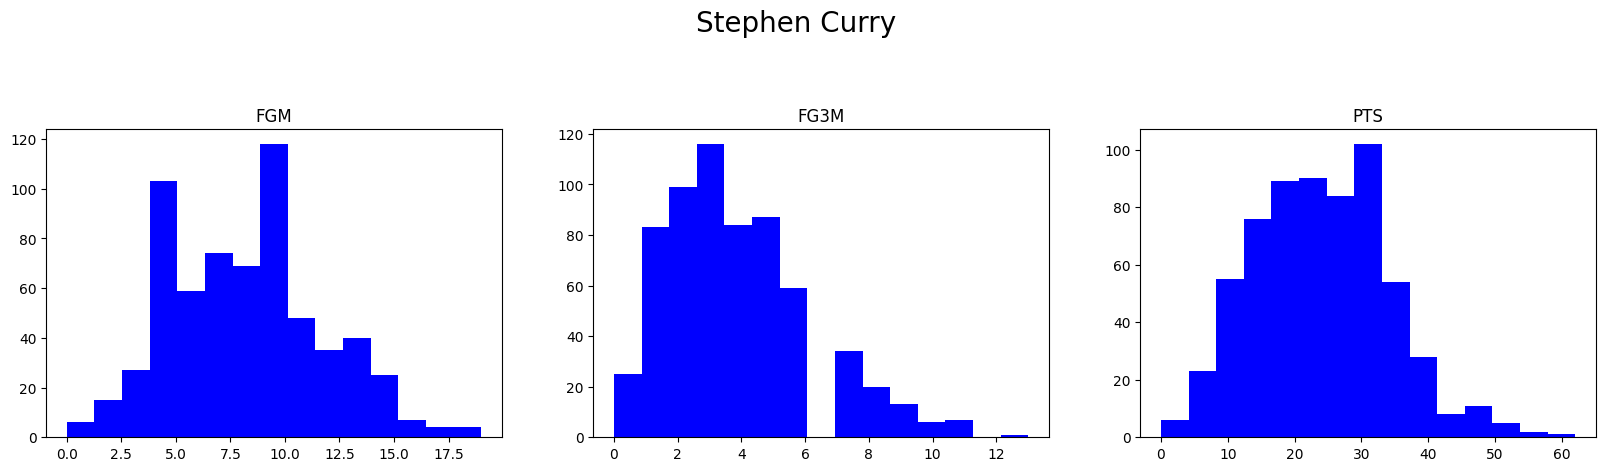

In [247]:
x = df_vitoria[df_vitoria['PLAYER_NAME'] == 'Stephen Curry']
lst = ['FGM','FG3M','PTS']
plt.figure(figsize=(20,12))
plt.suptitle('Stephen Curry', fontsize=20)
for i in range(len(lst)):
  plt.subplot(2,3,i+1)
  plt.subplots_adjust(hspace=1)
  plt.title(lst[i])
  plt.hist(x[lst[i]], bins=15, color='b')

In [ ]:
#Stephen Curry tem uma maior tendência de marcar pontos de três, e suas cestas de 2 pontos possuem uma tendência de serem em quantidades mais baixas (gráfico tendo a uma curva achatada)

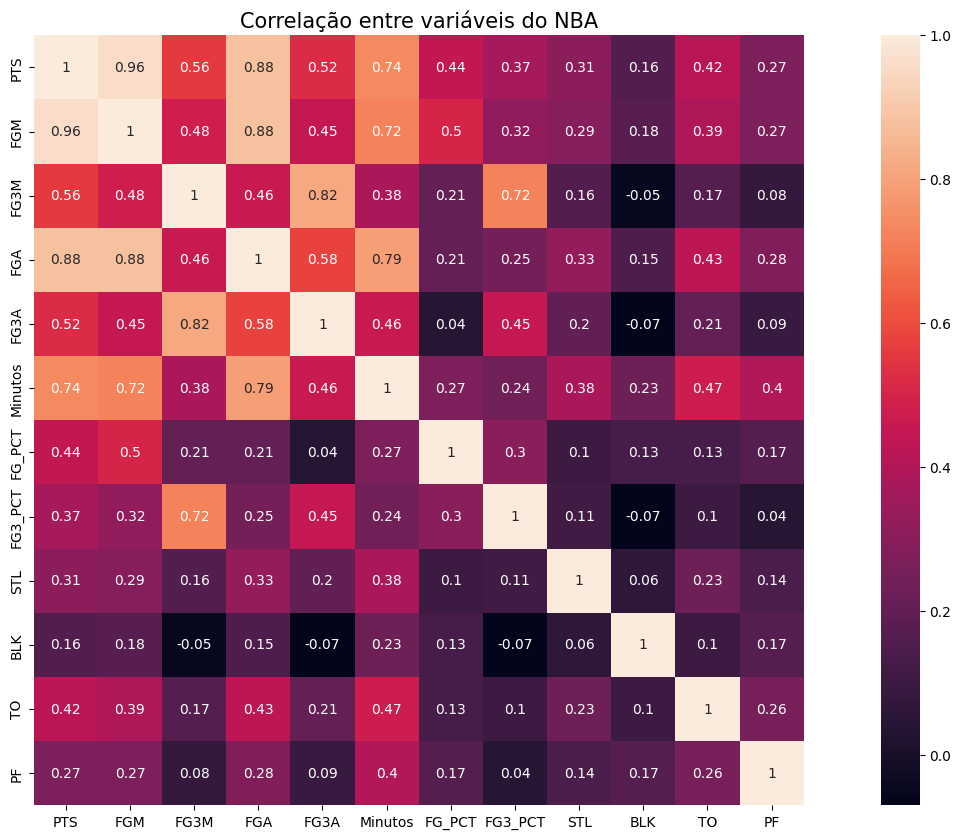

In [248]:
comrat1 = round(df[lista].corr(),2)

plt.figure(figsize=(20,10));
plt.title('Correlação entre variáveis do NBA',fontsize=15)
sns.heatmap(comrat1, vmax=1, square=True, annot=True);
plt.show();

In [ ]:
#percebemos que em jogos de NBA há maior correlação na quantidade de PTS por tentativas de cestas de dentro da área (0.88) do que de cestas de 3 pontos (0.52)
#e há mais correlação positiva entre o tempo jogado por pontos de dentro da área (FGA - Minutos = 0.79) que cestas de 3 (FG3A - Minutos = 0.46), as cestas se concentram mais dentro da área

<Figure size 640x480 with 0 Axes>

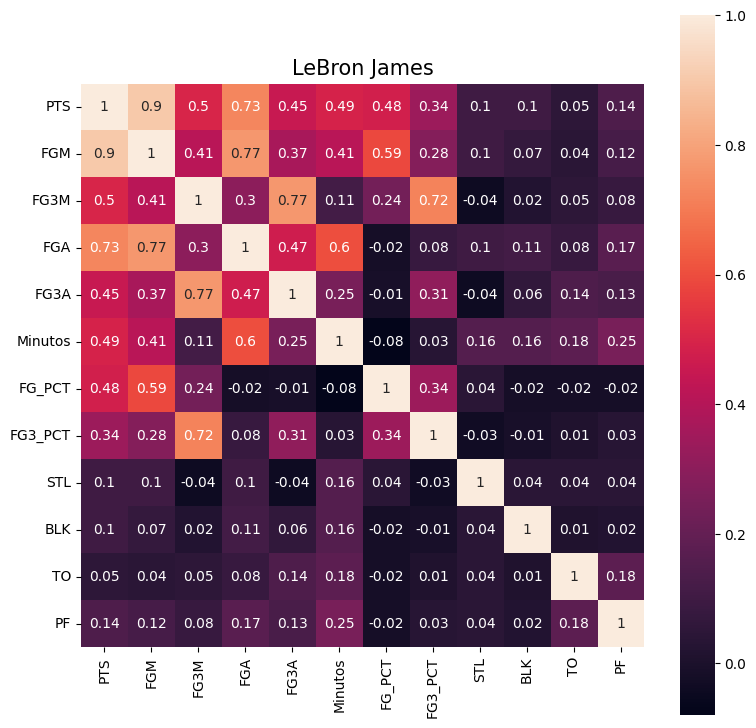

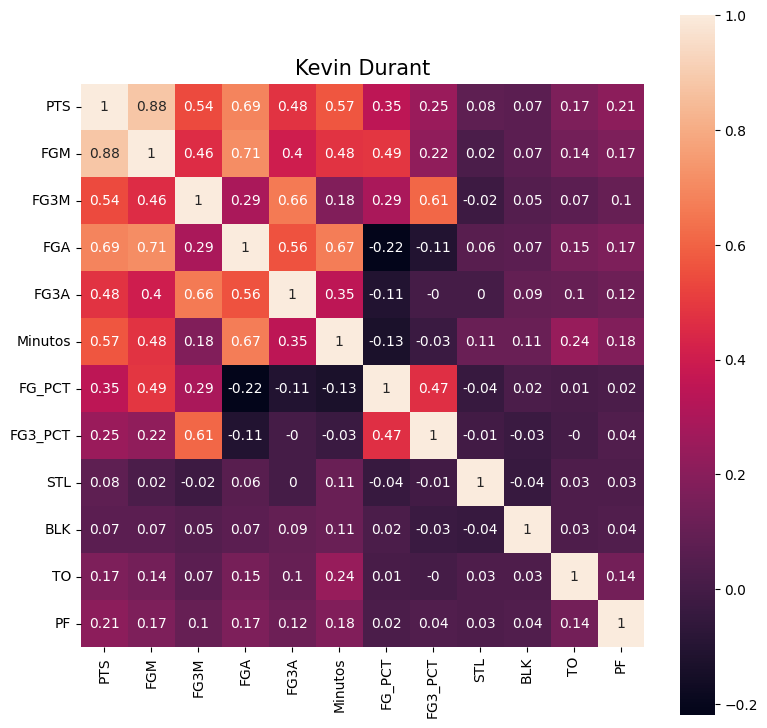

In [249]:
lista = [ 'PTS', 'FGM', 'FG3M', 'FGA', 'FG3A', 'Minutos',
       'FG_PCT', 'FG3_PCT', 'STL', 'BLK', 'TO', 'PF']

x = df.loc[df['PLAYER_NAME'] == 'LeBron James']
y = df.loc[df['PLAYER_NAME'] == 'Kevin Durant']

comrat1 = round(x[lista].corr(),2)
comrat2 = round(y[lista].corr(),2)


plt.subplots_adjust(hspace=0.8)

plt.figure(figsize=(20,20));
plt.subplot(2,2,1)
plt.title('LeBron James',fontsize=15)
sns.heatmap(comrat1, vmax=1, square=True, annot=True);
plt.show();

plt.figure(figsize=(20,20));
plt.subplot(2,2,2)
plt.title('Kevin Durant', fontsize=15)
sns.heatmap(comrat2, vmax=1, square=True, annot=True);
plt.show();

In [ ]:
#LeBron James possuí mais relação de PTS por tentativas de cestas de dentro da área(FGA)(0.73) que Kevin Durant com 0.69 - É mais provável que LeBron marque cestas de 2 que Kevin Durant

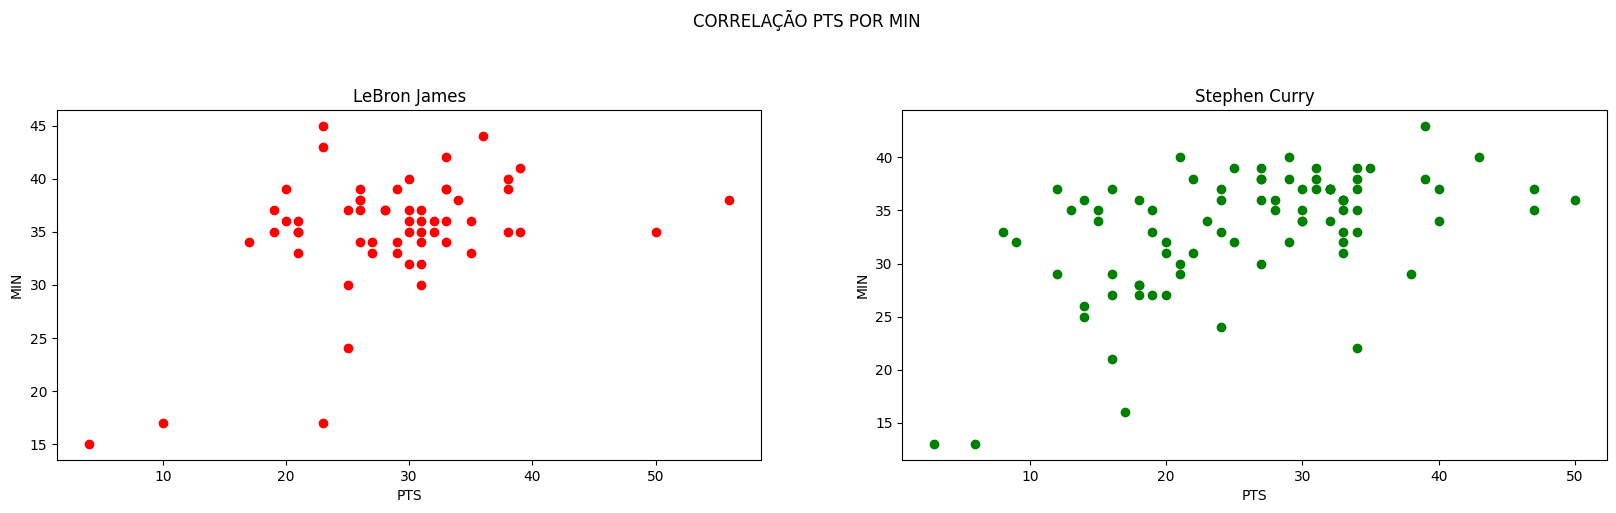

In [250]:
lst = ['2022-01','2022-02','2022-03','2022-04','2022-05','2022-06','2022-07','2022-08','2022-09','2022-10','2022-11','2022-12']
df1 = df[df['ANO'].isin(lst)]
x = df1.loc[df['PLAYER_NAME']=='LeBron James']
y = df1.loc[df['PLAYER_NAME']=='Stephen Curry']

plt.figure(figsize=(20,10))
plt.suptitle('CORRELAÇÃO PTS POR MIN')

plt.subplot(2,2,1)
plt.scatter(x['PTS'], x['Minutos'], vmin=0, vmax=100, color='red')
plt.title('LeBron James')
plt.xlabel('PTS')
plt.ylabel('MIN')


plt.subplot(2,2,2)
plt.scatter(y['PTS'], y['Minutos'], vmin=0, vmax=100, color='green')
plt.title('Stephen Curry')
plt.xlabel('PTS')
plt.ylabel('MIN')

plt.show()

In [ ]:
#LeBron, em 2022, teve mais performance entre 20 e 40 min e Stephen Curry mantém um alto desempenho entre 10 e 50 min

### **CÁLCULO DE PROBABILIDADE - DADOS VERIFICADOS COMO DISTRIBUIÇÕES NORMAIS**

---



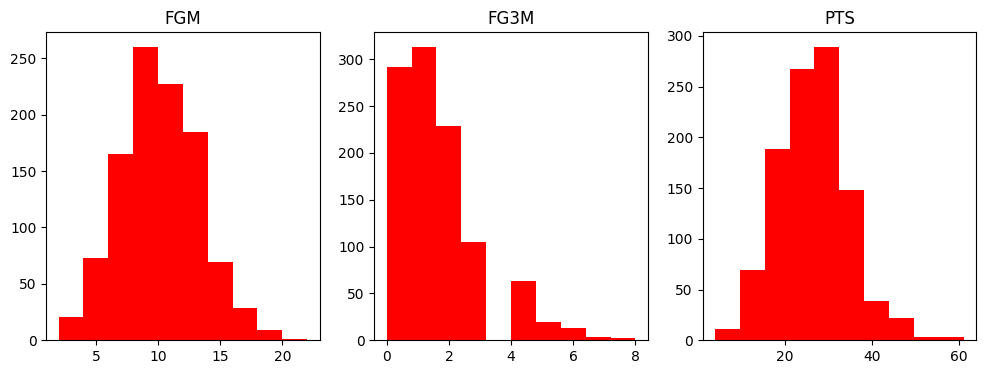

In [251]:
x = df_vitoria[df_vitoria['PLAYER_NAME'] == 'LeBron James']
lst = ['FGM','FG3M','PTS']
plt.figure(figsize=(12,12))
for i in range(len(lst)):
  plt.subplot(2,3,i+1)
  plt.subplots_adjust(hspace=1)
  plt.title(lst[i])
  plt.hist(x[lst[i]], color='r',)

In [252]:
x = df[df['PLAYER_NAME'] == 'LeBron James']
print(x['FGM'].mean())
print(x['FGM'].std())

9.771001150747987
3.238269513245181


In [253]:
round((norm.sf(15,9.771,3.2382)*100),2) #probabilidade de LeBron James ter Pontos de 2 maior que 15? = 5,32%

5.32

In [254]:
round((norm.cdf(10,9.7781,3.2382)*100),2) #probabilidade de LeBron marcar menos que 10 cestas de 2? = 52,73%

52.73

In [255]:
round((norm.sf(5,9.771,3.2382)*100),2) - round((norm.cdf(10,9.771,3.2382)*100),2) #Probabiliade de LeBron James marcar mais que 5 cestas de 2 e menos que 10? = 40,15%

40.15

### **PREVENDO PONTUAÇÕES DE LEBRON JAMES COM ARIMA**

---



In [340]:
ts = df.reset_index()
ts = ts[['PLAYER_NAME','FGM','ANO']]

In [341]:
ts['ANO'] = pd.DatetimeIndex(ts['ANO'])
ts.set_index('ANO', inplace=True)
ts = ts[ts['PLAYER_NAME']=='LeBron James']
ts = ts.groupby(by=ts.index).mean()

In [342]:
novo_indice = pd.date_range(start=ts.index.min(), end=ts.index.max(), freq='MS')

In [343]:
ts = ts.reindex(index=novo_indice)

In [347]:
datas_nulas = ts[ts['FGM'].isnull()].index
media_anual = ts.groupby(ts.index.month)['FGM'].median()
for data_nula in datas_nulas:
    mes = data_nula.month
    media = media_anual[mes]
    ts.at[data_nula, 'FGM'] = media
#para preencher dados nulos com sua média

In [331]:
#TIRANDO OUTLIERS
# Calcular o IQR
Q1 = ts['FGM'].quantile(0.25)
Q3 = ts['FGM'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identificar outliers
outliers = ts[(ts['FGM'] < lower_bound) | (ts['FGM'] > upper_bound)]

median_value = ts['FGM'].median()
ts['FGM'] = np.where((ts['FGM'] < lower_bound) | (ts['FGM'] > upper_bound), median_value, ts['FGM'])

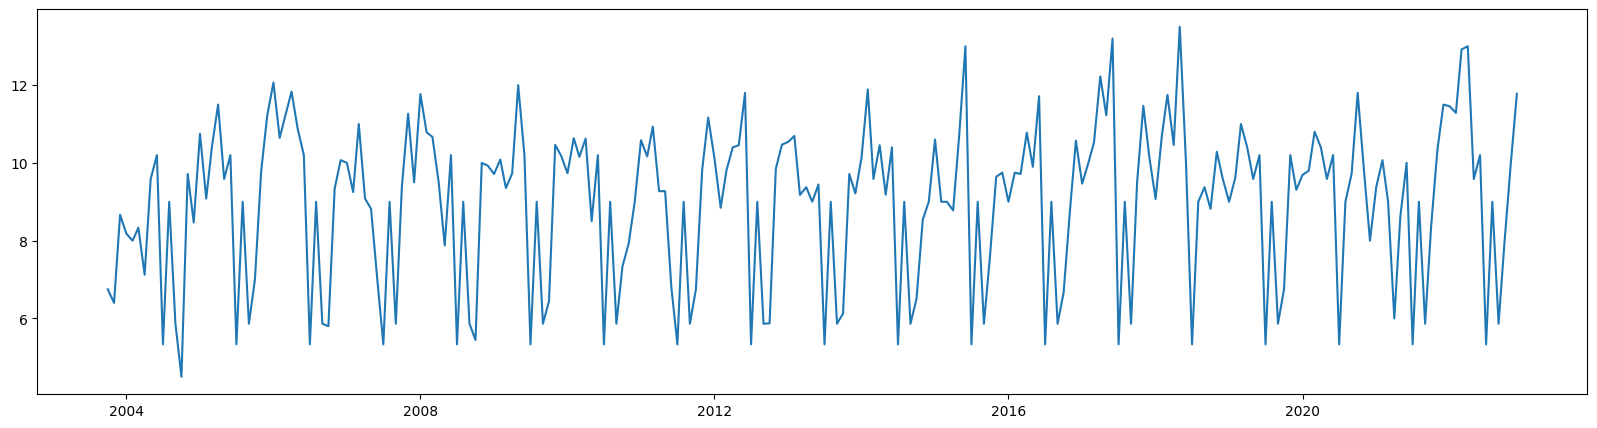

In [332]:
plt.figure(figsize=(20,5))
plt.plot(ts)

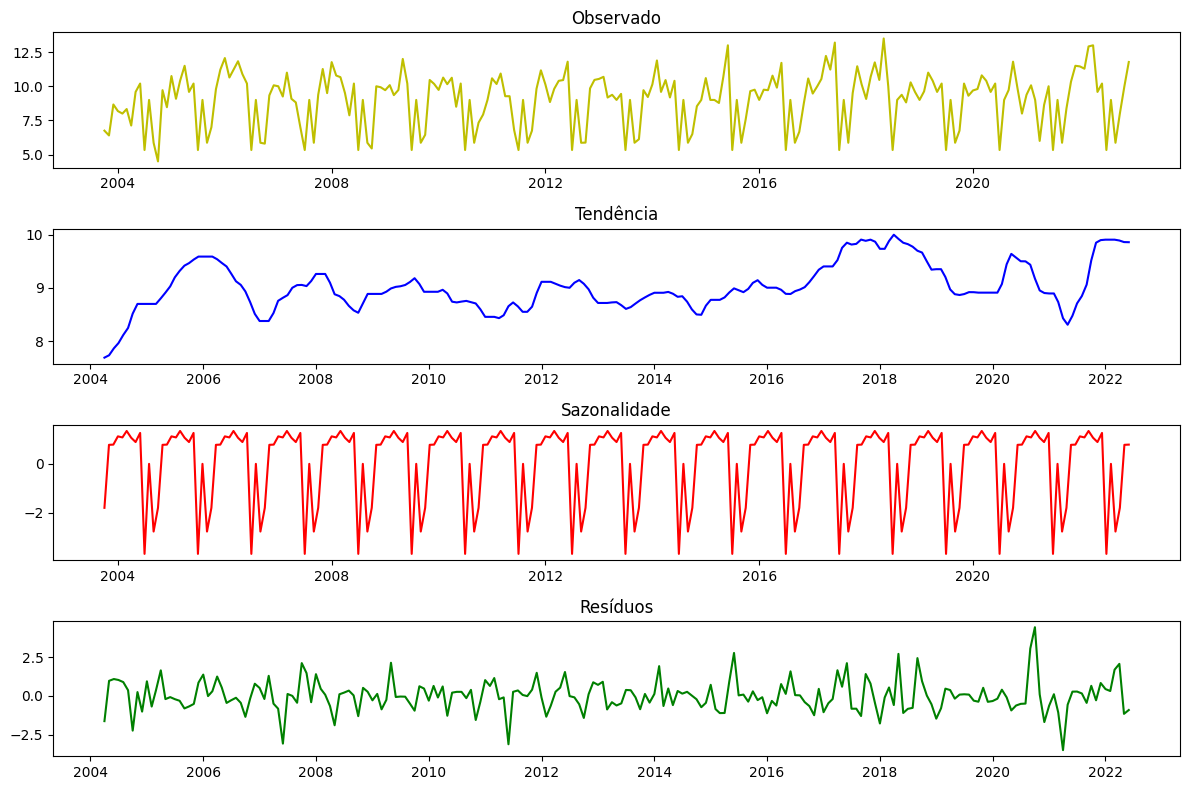

In [333]:
result = seasonal_decompose(ts['FGM'], model='additive')

plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(result.observed, color='y')
plt.title('Observado')
plt.subplot(4, 1, 2)
plt.plot(result.trend, color='b')
plt.title('Tendência')
plt.subplot(4, 1, 3)
plt.plot(result.seasonal, color='r')
plt.title('Sazonalidade')
plt.subplot(4, 1, 4)
plt.plot(result.resid, color='g')
plt.title('Resíduos')
plt.tight_layout()
plt.show()

In [334]:
stepwise_model = auto_arima(ts, start_p=0, start_q=0, start_d=0, start_P=0, max_p=8, max_q=8, m=12, seasonal=True,
                   stepwise=True) #criando modelo ARIMA

In [335]:
treino = ts.loc['2004-01-01':'2021-12-01']
teste = ts.loc['2022-01-01':] #fazendo o split de treino e teste

In [336]:
stepwise_model.fit(treino)

ARIMA(order=(1, 0, 0), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True)

In [337]:
future_forecasting = stepwise_model.predict(n_periods=24)

In [338]:
future = pd.DataFrame(future_forecasting, index=teste.index, columns=['FGM'])

<Axes: >

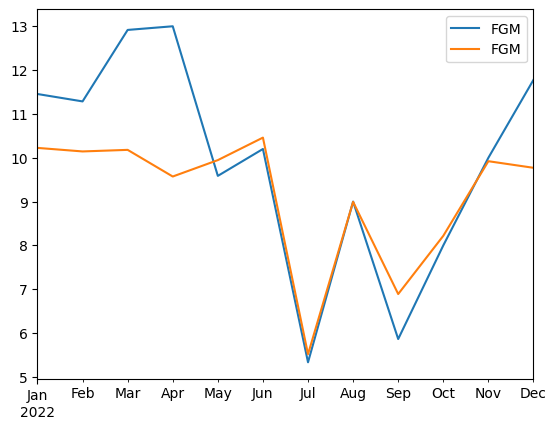

In [339]:
pd.concat([teste,future], axis=1).plot()

In [ ]:
#os meses de jan a abril e em dezembro o modelo não pode calcular a média de FGM coreta mas teve um bom desempenho entre maio e novembro

In [348]:
future2 = pd.DataFrame(future_forecasting, columns=['FGM'])

<Axes: >

<Figure size 3000x1000 with 0 Axes>

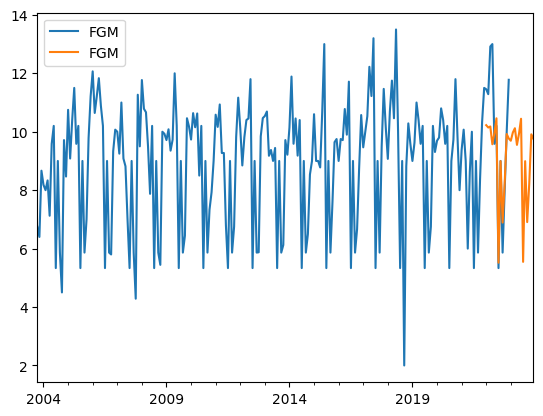

In [349]:
plt.figure(figsize=(30,10))
pd.concat([ts,future2], axis=1).plot()

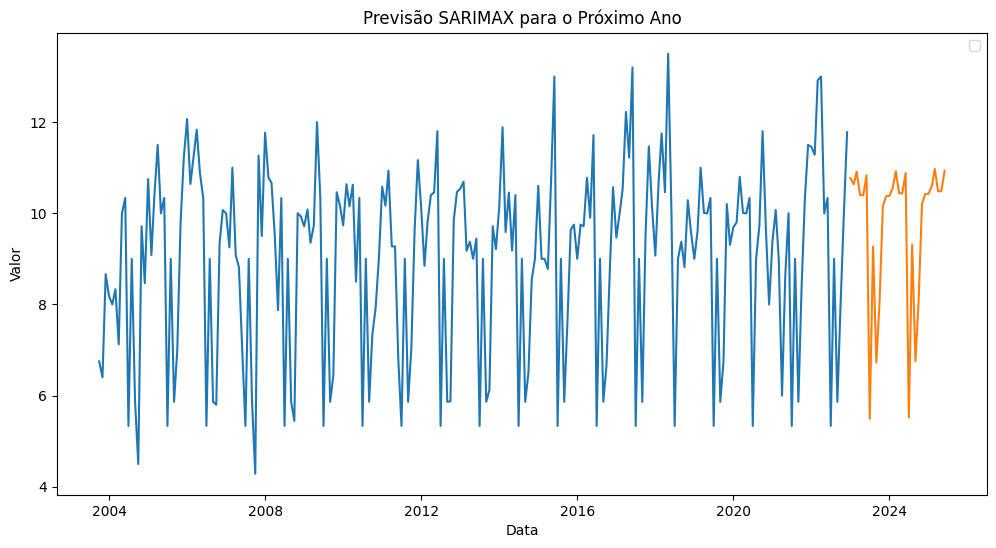

In [306]:
import statsmodels.api as sm
# Ajustar o modelo SARIMAX
order = (1, 0, 0)  # Especifique a ordem do modelo ARIMA (p, d, q)
seasonal_order = (1, 0, 1, 12)  # Ordem sazonal (P, D, Q, S)
model = sm.tsa.SARIMAX(ts['FGM'], order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
results = model.fit()

# Fazer previsões para o próximo ano (365 dias)
forecast = results.get_forecast(steps=365)
forecast_values = forecast.predicted_mean

# Visualizar as previsões
plt.figure(figsize=(12, 6))
plt.plot(ts)
plt.plot(forecast_values[0:30])
plt.title('Previsão SARIMAX para o Próximo Ano')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.legend()
plt.show()